In [656]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd
import overpass
import requests
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [904]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [905]:
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704
421,uNw6t6xk,37.586825,55.794233,-0.002397
422,Ap42ei8k,37.678790,55.772910,-0.910019
423,rn9A8r62,37.752130,55.619640,-0.326547


In [906]:
test

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.748040,0.0091
1,4LJu4GTf,60.580910,56.795860,0.0091
2,kLuAAN3s,37.598614,55.781357,0.0091
3,OxQHvaNu,37.794051,55.717468,0.0091
4,paQsTa1K,49.213026,55.748290,0.0091
...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091
103,4nmfqUw0,92.928927,56.116262,0.0091
104,N9O45mAh,93.015993,56.023697,0.0091
105,h2InCLKa,30.381172,59.871149,0.0091


In [907]:
train = pd.concat([train, test])
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.009100
103,4nmfqUw0,92.928927,56.116262,0.009100
104,N9O45mAh,93.015993,56.023697,0.009100
105,h2InCLKa,30.381172,59.871149,0.009100


In [334]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  relation
    ["place"="city"]
    (area);
  out geom;

  relation
    ["place"="town"]
    (area);
  out geom;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
cities = response.json()

In [352]:
"""
coords = []
for coord in cities['elements'][2]['members'][0]['geometry']:   
    coords.append(Point(coord['lon'], coord['lat']))
coords.append(Point(cities['elements'][2]['members'][0]['geometry'][0]['lon'], 
                    cities['elements'][2]['members'][0]['geometry'][0]['lat']))
pol = []
pol.append(Polygon(coords))
#Polygon(coords)
coords = []
for coord in cities['elements'][2]['members'][1]['geometry']:   
    coords.append(Point(coord['lon'], coord['lat']))
coords.append(Point(cities['elements'][2]['members'][1]['geometry'][0]['lon'], 
                    cities['elements'][2]['members'][1]['geometry'][0]['lat']))
#Polygon(coords)
pol.append(Polygon(coords))


MultiPolygon(pol)
"""

"\ncoords = []\nfor coord in cities['elements'][2]['members'][0]['geometry']:   \n    coords.append(Point(coord['lon'], coord['lat']))\ncoords.append(Point(cities['elements'][2]['members'][0]['geometry'][0]['lon'], \n                    cities['elements'][2]['members'][0]['geometry'][0]['lat']))\npol = []\npol.append(Polygon(coords))\n#Polygon(coords)\ncoords = []\nfor coord in cities['elements'][2]['members'][1]['geometry']:   \n    coords.append(Point(coord['lon'], coord['lat']))\ncoords.append(Point(cities['elements'][2]['members'][1]['geometry'][0]['lon'], \n                    cities['elements'][2]['members'][1]['geometry'][0]['lat']))\n#Polygon(coords)\npol.append(Polygon(coords))\n\n\nMultiPolygon(pol)\n"

In [329]:
"""
from shapely.geometry import Point, Polygon, MultiPolygon

geom = []
for city in cities['elements']:
    if city['type'] == 'relation':
        pol = []
        for member in city['members']:
            if(member['type'] == 'way'):
                coords = []
                for coord in member['geometry']:
                    coords.append(Point(coord['lat'], coord['lon']))
                coords.append(Point(member['geometry'][0]['lat'], member['geometry'][0]['lon']))
                pol.append(Polygon(coords))
        geom.append((MultiPolygon(pol), city['tags']['name'] ))
"""

In [861]:
from shapely.geometry import Point, Polygon, MultiPolygon

pol = []
for city in cities['elements']:
    if city['type'] == 'relation':
        coords = []
        for member in city['members']:
            if(member['type'] == 'way'):
                for coord in member['geometry']:
                    coords.append(Point(coord['lat'], coord['lon']))
        #coords.append(coords[0])
        pol.append((Polygon(coords), city['tags']['name']))

In [214]:
"""
main_data = []
for element in cities['elements']:
    if element['type'] == 'relation':
        pol = Polygon(((element['bounds']['minlon'], element['bounds']['minlat']),
                       (element['bounds']['minlon'], element['bounds']['maxlat']),
                       (element['bounds']['maxlon'], element['bounds']['maxlat']),
                       (element['bounds']['maxlon'], element['bounds']['minlat']),
                      (element['bounds']['minlon'], element['bounds']['minlat'])))
        main_data.append((pol, element['tags']['name']))
X = np.array(main_data)
print(X)
"""

"\nmain_data = []\nfor element in cities['elements']:\n    if element['type'] == 'relation':\n        pol = Polygon(((element['bounds']['minlon'], element['bounds']['minlat']),\n                       (element['bounds']['minlon'], element['bounds']['maxlat']),\n                       (element['bounds']['maxlon'], element['bounds']['maxlat']),\n                       (element['bounds']['maxlon'], element['bounds']['minlat']),\n                      (element['bounds']['minlon'], element['bounds']['minlat'])))\n        main_data.append((pol, element['tags']['name']))\nX = np.array(main_data)\nprint(X)\n"

In [349]:
"""
npgeom = np.array(geom)
geom_gdf = gpd.GeoDataFrame(npgeom)
geom_gdf = geom_gdf.rename(columns={0: 'geometry', 1: 'city'}).set_geometry('geometry')
"""

"\nnpgeom = np.array(geom)\ngeom_gdf = gpd.GeoDataFrame(npgeom)\ngeom_gdf = geom_gdf.rename(columns={0: 'geometry', 1: 'city'}).set_geometry('geometry')\n"

In [908]:
train['geometry'] = [Point(x,y) for x,y in zip(train.lat, train.lon)]
train = train.drop(['lat', 'lon'], axis = 1)
test['geometry'] = [Point(x,y) for x,y in zip(test.lat, test.lon)]
test = test.drop(['lat', 'lon'], axis = 1)
train

,point_id,target,geometry
0,ommNZCUV,-0.348157,POINT (55.84863000000001 37.590776)
1,nMe2LHPb,1.294206,POINT (55.750271 37.78421)
2,ZgodVRqB,-1.039679,POINT (47.21333 39.635721)
3,0t2jNYdz,-1.169339,POINT (55.78202 37.70457)
4,U27W4QJ7,-0.088837,POINT (55.730188 37.643983)
...,...,...,...
102,y8oQuX5v,0.009100,POINT (60.049792 30.353777)
103,4nmfqUw0,0.009100,POINT (56.116262 92.928927)
104,N9O45mAh,0.009100,POINT (56.023697 93.01599299999999)
105,h2InCLKa,0.009100,POINT (59.871149 30.381172)


In [909]:
nppol = np.array(pol)
pol_gdf = gpd.GeoDataFrame(nppol)
pol_gdf = pol_gdf.rename(columns={0: 'geometry', 1: 'city'}).set_geometry('geometry')

In [910]:
train = gpd.GeoDataFrame(train)
new = gpd.sjoin( pol_gdf, train, how="right", op='contains')
new

,index_left,city,point_id,target,geometry
20,4.0,Колпино,wQOQvE03,-1.126119,POINT (59.73553 30.57983)
346,4.0,Колпино,2kUlAO0h,-1.039679,POINT (59.74039 30.58293)
208,4.0,Колпино,DvEZb53r,-1.212559,POINT (59.74071 30.61053)
183,4.0,Колпино,rkhUhnnc,-0.650698,POINT (59.73877 30.62202)
332,5.0,Пушкин,avEOHzEY,0.127264,POINT (59.72149 30.42787)
...,...,...,...,...,...
385,NaN,NaN,6pVArqoM,-1.212559,POINT (59.90961 29.77714)
21,NaN,NaN,hfO83LAD,0.009100,POINT (56.23348 43.83525)
41,NaN,NaN,ZeaM9y86,0.009100,POINT (54.70603 55.82929)
89,NaN,NaN,Fk1RC0V1,0.009100,POINT (55.97888 37.17152)


In [911]:
cols = ['city']
dtrain = new.dropna(subset = cols)
dtrain = dtrain.reset_index(drop = True)
dtrain

,index_left,city,point_id,target,geometry
0,4.0,Колпино,wQOQvE03,-1.126119,POINT (59.73553 30.57983)
1,4.0,Колпино,2kUlAO0h,-1.039679,POINT (59.74039 30.58293)
2,4.0,Колпино,DvEZb53r,-1.212559,POINT (59.74071 30.61053)
3,4.0,Колпино,rkhUhnnc,-0.650698,POINT (59.73877 30.62202)
4,5.0,Пушкин,avEOHzEY,0.127264,POINT (59.72149 30.42787)
...,...,...,...,...,...
498,152.0,Екатеринбург,HmjxRHVs,-0.391377,POINT (56.79686 60.62619)
499,152.0,Екатеринбург,AnEwYKsf,-0.693918,POINT (56.83812 60.63681)
500,152.0,Екатеринбург,pmpDwkBu,-1.342220,POINT (56.78855 60.64902)
501,152.0,Екатеринбург,J4kyyZ66,-0.910019,POINT (56.75456 60.70136)


In [872]:
from functools import partial
import pyproj
from shapely.ops import transform

wgs84_globe = pyproj.Proj(proj='longlat', ellps='WGS84')
def pol_buff_on_globe(_lat, _lon, km):
    aeqd = pyproj.Proj(proj='aeqd', ellps='WGS84', datum='WGS84',
                       lat_0=_lat, lon_0=_lon)
    buf = Point(0, 0).buffer(km * 1000)
    return transform( partial(pyproj.transform, aeqd, wgs84_globe),
                          buf)




In [874]:
geodesic_buffers1 = gpd.GeoDataFrame()
geodesic_buffers1['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 1), axis=1)

geodesic_buffers3 = gpd.GeoDataFrame()
geodesic_buffers3['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 3), axis=1)

geodesic_buffers5 = gpd.GeoDataFrame()
geodesic_buffers5['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 5), axis=1)

In [413]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["railway"="station"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
stations = response.json()

In [875]:
station_lat = []
station_lon = []
for station in stations['elements']:
    if station['type'] == 'node':
        station_lat.append(station['lat'])
        station_lon.append(station['lon'])
#npstation = np.array(station_points)
df = pd.DataFrame(
    {'Latitude': station_lat,
     'Longitude': station_lon})
station_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude,  df.Latitude))
station_gdf

,geometry
0,POINT (33.71117 60.74938)
1,POINT (33.31425 60.62221)
2,POINT (30.35477 59.99046)
3,POINT (30.42501 59.98820)
4,POINT (34.25039 61.94111)
...,...
12715,POINT (123.61851 55.43019)
12716,POINT (123.94023 55.33259)
12717,POINT (93.37648 54.29532)
12718,POINT (37.26606 55.60996)


In [876]:
buffer_stations1 = gpd.sjoin(geodesic_buffers1, station_gdf, how="left", op='contains')
buffer_stations1 = buffer_stations1.groupby(level=0).index_right.count()
buffer_stations3 = gpd.sjoin(geodesic_buffers3, station_gdf, how="left", op='contains')
buffer_stations3 = buffer_stations3.groupby(level=0).index_right.count()
buffer_stations5 = gpd.sjoin(geodesic_buffers5, station_gdf, how="left", op='contains')
buffer_stations5 = buffer_stations5.groupby(level=0).index_right.count()

In [912]:
dtrain['Station on 1 km'] = buffer_stations1
dtrain = dtrain.drop(['index_left'], axis=1)
dtrain['Station on 3 km'] = buffer_stations3
dtrain['Station on 5 km'] = buffer_stations5
dtrain

,city,point_id,target,geometry,Station on 1 km,Station on 3 km,Station on 5 km
0,Колпино,wQOQvE03,-1.126119,POINT (59.73553 30.57983),0,2,2
1,Колпино,2kUlAO0h,-1.039679,POINT (59.74039 30.58293),0,2,2
2,Колпино,DvEZb53r,-1.212559,POINT (59.74071 30.61053),0,2,2
3,Колпино,rkhUhnnc,-0.650698,POINT (59.73877 30.62202),0,2,2
4,Пушкин,avEOHzEY,0.127264,POINT (59.72149 30.42787),2,4,6
...,...,...,...,...,...,...,...
498,Екатеринбург,HmjxRHVs,-0.391377,POINT (56.79686 60.62619),2,8,16
499,Екатеринбург,AnEwYKsf,-0.693918,POINT (56.83812 60.63681),0,12,26
500,Екатеринбург,pmpDwkBu,-1.342220,POINT (56.78855 60.64902),0,4,16
501,Екатеринбург,J4kyyZ66,-0.910019,POINT (56.75456 60.70136),0,0,4


In [476]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["place"="city"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
city_centers = response.json()

In [878]:
centers_lat = []
centers_lon = []
centers_name = []
population = []
for center in city_centers['elements']:
    if center['type'] == 'node':
        centers_lat.append(center['lat'])
        centers_lon.append(center['lon'])
        centers_name.append(center['tags']['name'])
        population.append(center['tags']['population'])
df = pd.DataFrame(
    {'Latitude': centers_lat,
     'Longitude': centers_lon,
     'city': centers_name,
     'population': population})
city_centers_gdf = gpd.GeoDataFrame(
    df.city, geometry= gpd.points_from_xy(df.Latitude, df.Longitude))
city_centers_gdf['population'] = df['population']
city_centers_gdf

,city,geometry,population
0,Новосибирск,POINT (55.028 82.923),1625600
1,Северодвинск,POINT (64.563 39.824),183255
2,Петрозаводск,POINT (61.790 34.390),280170
3,Вологда,POINT (59.219 39.893),311166
4,Тверь,POINT (56.859 35.921),420850
...,...,...,...
369,Салават,POINT (53.362 55.925),153973
370,Бийск,POINT (52.539 85.215),200629
371,Магадан,POINT (59.560 150.799),92782
372,Сызрань,POINT (53.155 48.474),174599


In [913]:
dtrain = dtrain.merge(city_centers_gdf, how = 'left', on='city')
dtrain = dtrain.groupby(by = 'point_id').first()
dtrain = dtrain.rename(columns={'geometry_x': 'geometry', 'geometry_y': 'city_center'}).set_geometry('geometry', 'city_center')
dtrain = dtrain.reset_index()
dtrain

,point_id,city,target,Station on 1 km,Station on 3 km,Station on 5 km,city_center,population,geometry
0,09nncz2H,Москва,0.009100,4,24,42,POINT (55.75045 37.61749),12630289,POINT (55.79459 37.49205)
1,0BYKB88d,Новосибирск,-0.391377,4,10,18,POINT (55.02822 82.92345),1625600,POINT (54.98404 82.89095)
2,0dALVmD0,Самара,0.009100,2,10,22,POINT (53.19863 50.11399),1156644,POINT (53.20738 50.19788)
3,0eSE1PRt,Москва,-0.304937,2,12,26,POINT (55.75045 37.61749),12630289,POINT (55.68374 37.49105)
4,0t2jNYdz,Москва,-1.169339,2,20,80,POINT (55.75045 37.61749),12630289,POINT (55.78202 37.70457)
...,...,...,...,...,...,...,...,...,...
498,zq24zBHA,Новосибирск,0.127264,6,30,50,POINT (55.02822 82.92345),1625600,POINT (55.03455 82.89944)
499,zqxBvgo3,Москва,0.473024,2,22,62,POINT (55.75045 37.61749),12630289,POINT (55.68966 37.60242)
500,zrqrRf0q,Уфа,-0.650698,0,0,2,POINT (54.72614 55.94750),1110976,POINT (54.71807 55.98667)
501,zynEGrYK,Новосибирск,1.294206,6,26,46,POINT (55.02822 82.92345),1625600,POINT (55.05965 82.91410)


In [914]:
from geopy import distance

dist_to_center = []
for c in range(dtrain['geometry'].size):
    dist_to_center.append(round(distance.geodesic((dtrain.iloc[c]['geometry'].x, dtrain.iloc[c]['geometry'].y), 
                                  (dtrain.iloc[c]['city_center'].x, dtrain.iloc[c]['city_center'].y)).km, 3))
dtrain['dist to center'] = dist_to_center
dtrain = dtrain.drop(['city_center'], axis=1)
dtrain

,point_id,city,target,Station on 1 km,Station on 3 km,Station on 5 km,population,geometry,dist to center
0,09nncz2H,Москва,0.009100,4,24,42,12630289,POINT (55.79459 37.49205),9.281
1,0BYKB88d,Новосибирск,-0.391377,4,10,18,1625600,POINT (54.98404 82.89095),5.340
2,0dALVmD0,Самара,0.009100,2,10,22,1156644,POINT (53.20738 50.19788),5.690
3,0eSE1PRt,Москва,-0.304937,2,12,26,12630289,POINT (55.68374 37.49105),10.877
4,0t2jNYdz,Москва,-1.169339,2,20,80,12630289,POINT (55.78202 37.70457),6.499
...,...,...,...,...,...,...,...,...,...
498,zq24zBHA,Новосибирск,0.127264,6,30,50,1625600,POINT (55.03455 82.89944),1.689
499,zqxBvgo3,Москва,0.473024,2,22,62,12630289,POINT (55.68966 37.60242),6.834
500,zrqrRf0q,Уфа,-0.650698,0,0,2,1110976,POINT (54.71807 55.98667),2.679
501,zynEGrYK,Новосибирск,1.294206,6,26,46,1625600,POINT (55.05965 82.91410),3.550


In [620]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["tourism"="hotel"] 
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
hotels = response.json()

In [881]:
hotels_lat = []
hotels_lon = []
for hotel in hotels['elements']:
    if hotel['type'] == 'node':
        hotels_lat.append(hotel['lat'])
        hotels_lon.append(hotel['lon'])
df = pd.DataFrame(
    {'Latitude': hotels_lat,
     'Longitude': hotels_lon})
hotels_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude, df.Latitude))

geodesic_buffers5 = gpd.GeoDataFrame()
geodesic_buffers5['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 5), axis=1)

geodesic_buffers2 = gpd.GeoDataFrame()
geodesic_buffers2['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 2), axis=1)

In [915]:
buffer_hotels2 = gpd.sjoin(geodesic_buffers2, hotels_gdf, how="left", op='contains')
buffer_hotels2 = buffer_hotels2.groupby(level=0).index_right.count()
buffer_hotels5 = gpd.sjoin(geodesic_buffers5, hotels_gdf, how="left", op='contains')
buffer_hotels5 = buffer_hotels5.groupby(level=0).index_right.count()
dtrain['Hotels on 2 km'] = buffer_hotels2
dtrain['Hotels on 5 km'] = buffer_hotels5
dtrain

,point_id,city,target,Station on 1 km,Station on 3 km,Station on 5 km,population,geometry,dist to center,Hotels on 2 km,Hotels on 5 km
0,09nncz2H,Москва,0.009100,4,24,42,12630289,POINT (55.79459 37.49205),9.281,0,2
1,0BYKB88d,Новосибирск,-0.391377,4,10,18,1625600,POINT (54.98404 82.89095),5.340,0,0
2,0dALVmD0,Самара,0.009100,2,10,22,1156644,POINT (53.20738 50.19788),5.690,0,0
3,0eSE1PRt,Москва,-0.304937,2,12,26,12630289,POINT (55.68374 37.49105),10.877,0,2
4,0t2jNYdz,Москва,-1.169339,2,20,80,12630289,POINT (55.78202 37.70457),6.499,0,16
...,...,...,...,...,...,...,...,...,...,...,...
498,zq24zBHA,Новосибирск,0.127264,6,30,50,1625600,POINT (55.03455 82.89944),1.689,2,4
499,zqxBvgo3,Москва,0.473024,2,22,62,12630289,POINT (55.68966 37.60242),6.834,2,6
500,zrqrRf0q,Уфа,-0.650698,0,0,2,1110976,POINT (54.71807 55.98667),2.679,2,4
501,zynEGrYK,Новосибирск,1.294206,6,26,46,1625600,POINT (55.05965 82.91410),3.550,0,2


In [830]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];

  area
    ["ISO3166-1"="RU"]
    ["boundary"="administrative"]
    [admin_level=2];
  out;

  node
    ["amenity"="marketplace"]
    (area);
  out geom;

out body;
>;
out skel qt;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
markets = response.json()

In [883]:
market_lat = []
market_lon = []
for market in markets['elements']:
    if market['type'] == 'node':
        market_lat.append(market['lat'])
        market_lon.append(market['lon'])
df = pd.DataFrame(
    {'Latitude': market_lat,
     'Longitude': market_lon})
hotels_gdf = gpd.GeoDataFrame(
    geometry= gpd.points_from_xy(df.Longitude, df.Latitude))

geodesic_buffers_market1 = gpd.GeoDataFrame()
geodesic_buffers_market1['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 1), axis=1)

geodesic_buffers_market2 = gpd.GeoDataFrame()
geodesic_buffers_market2['geometry'] = gpd.GeoDataFrame(
    geometry=[x for x in dtrain["geometry"]]
).apply(lambda x: pol_buff_on_globe(x['geometry'].x, x['geometry'].y, 2), axis=1)

In [916]:
buffer_market1 = gpd.sjoin(geodesic_buffers_market1, hotels_gdf, how="left", op='contains')
buffer_market1 = buffer_market1.groupby(level=0).index_right.count()
buffer_market2 = gpd.sjoin(geodesic_buffers_market2, hotels_gdf, how="left", op='contains')
buffer_market2 = buffer_market2.groupby(level=0).index_right.count()
dtrain['Markets on 1 km'] = buffer_market1
dtrain['Markets on 2 km'] = buffer_market2
dtrain

,point_id,city,target,Station on 1 km,Station on 3 km,Station on 5 km,population,geometry,dist to center,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,09nncz2H,Москва,0.009100,4,24,42,12630289,POINT (55.79459 37.49205),9.281,0,2,0,0
1,0BYKB88d,Новосибирск,-0.391377,4,10,18,1625600,POINT (54.98404 82.89095),5.340,0,0,0,0
2,0dALVmD0,Самара,0.009100,2,10,22,1156644,POINT (53.20738 50.19788),5.690,0,0,0,0
3,0eSE1PRt,Москва,-0.304937,2,12,26,12630289,POINT (55.68374 37.49105),10.877,0,2,0,0
4,0t2jNYdz,Москва,-1.169339,2,20,80,12630289,POINT (55.78202 37.70457),6.499,0,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,zq24zBHA,Новосибирск,0.127264,6,30,50,1625600,POINT (55.03455 82.89944),1.689,2,4,2,2
499,zqxBvgo3,Москва,0.473024,2,22,62,12630289,POINT (55.68966 37.60242),6.834,2,6,0,2
500,zrqrRf0q,Уфа,-0.650698,0,0,2,1110976,POINT (54.71807 55.98667),2.679,2,4,0,2
501,zynEGrYK,Новосибирск,1.294206,6,26,46,1625600,POINT (55.05965 82.91410),3.550,0,2,0,0


In [917]:
ytrain = dtrain.target
df_geometry = dtrain.geometry
df_city = dtrain.city
dtrain = dtrain.drop(['city', 'geometry'], axis=1)
dtrain

,point_id,target,Station on 1 km,Station on 3 km,Station on 5 km,population,dist to center,Hotels on 2 km,Hotels on 5 km,Markets on 1 km,Markets on 2 km
0,09nncz2H,0.009100,4,24,42,12630289,9.281,0,2,0,0
1,0BYKB88d,-0.391377,4,10,18,1625600,5.340,0,0,0,0
2,0dALVmD0,0.009100,2,10,22,1156644,5.690,0,0,0,0
3,0eSE1PRt,-0.304937,2,12,26,12630289,10.877,0,2,0,0
4,0t2jNYdz,-1.169339,2,20,80,12630289,6.499,0,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...
498,zq24zBHA,0.127264,6,30,50,1625600,1.689,2,4,2,2
499,zqxBvgo3,0.473024,2,22,62,12630289,6.834,2,6,0,2
500,zrqrRf0q,-0.650698,0,0,2,1110976,2.679,2,4,0,2
501,zynEGrYK,1.294206,6,26,46,1625600,3.550,0,2,0,0


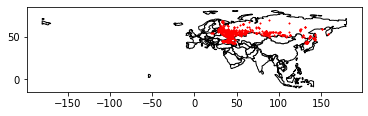

In [946]:
df_lat = []
df_lon = []
for i in df_geometry:
    df_lat.append(i.x)
    df_lon.append(i.y)
df_map = pd.DataFrame(
    {'City': df_city,
     'Longitude': df_lon,
     'Latitude': df_lat})

gdf_map = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

europe = world[world.continent == 'Europe']
asia = world[world.continent == 'Asia']
eurasia = europe.append(asia)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = eurasia.plot(
    color='white', edgecolor='black')
gdf_map.plot(ax=ax, color='red', markersize = 0.5)
plt.show()

In [955]:
from keplergl import KeplerGl
kg_map = KeplerGl(height = 500)
#kg_map.add_data(gdf_map)
kg_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=500)

In [961]:
mapa = folium.Map([-15.783333, -47.866667],
                  zoom_start=4,
                  tiles='cartodbpositron')

points = folium.features.GeoJson(gdf_map.to_json())

mapa.add_children(points)
mapa

### Fit model

In [849]:
#X_train, X_valid, y_train, y_valid = train_test_split(dtrain.drop('target', axis=1), dtrain[['target']])
#model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [850]:
#mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6958944500753261

In [851]:
from catboost import CatBoostRegressor
mae = 0
for i in range(20):
    X_train, X_valid, y_train, y_valid = train_test_split(dtrain.drop('target', axis=1), dtrain[['target']])
    model = CatBoostRegressor(iterations=300, loss_function='MAE').fit(X_train.drop('point_id', axis=1), y_train)
    mae += mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))
print(mae/20)

0:	learn: 0.6892587	total: 3.14ms	remaining: 940ms
1:	learn: 0.6867899	total: 5.51ms	remaining: 821ms
2:	learn: 0.6841832	total: 10ms	remaining: 994ms
3:	learn: 0.6805880	total: 11.5ms	remaining: 850ms
4:	learn: 0.6778797	total: 13.6ms	remaining: 801ms
5:	learn: 0.6745047	total: 15.6ms	remaining: 766ms
6:	learn: 0.6725209	total: 20.3ms	remaining: 848ms
7:	learn: 0.6709907	total: 22.5ms	remaining: 822ms
8:	learn: 0.6682892	total: 25ms	remaining: 809ms
9:	learn: 0.6664708	total: 27.8ms	remaining: 807ms
10:	learn: 0.6640975	total: 34.7ms	remaining: 911ms
11:	learn: 0.6609779	total: 36.2ms	remaining: 869ms
12:	learn: 0.6591740	total: 38.4ms	remaining: 848ms
13:	learn: 0.6560385	total: 41.1ms	remaining: 839ms
14:	learn: 0.6539498	total: 43.4ms	remaining: 824ms
15:	learn: 0.6518895	total: 45ms	remaining: 798ms
16:	learn: 0.6495742	total: 46.3ms	remaining: 771ms
17:	learn: 0.6477470	total: 48.1ms	remaining: 754ms
18:	learn: 0.6457354	total: 50.2ms	remaining: 743ms
19:	learn: 0.6440628	total: 

246:	learn: 0.4640434	total: 356ms	remaining: 76.4ms
247:	learn: 0.4632739	total: 362ms	remaining: 75.9ms
248:	learn: 0.4632120	total: 365ms	remaining: 74.7ms
249:	learn: 0.4626671	total: 367ms	remaining: 73.4ms
250:	learn: 0.4623074	total: 373ms	remaining: 72.8ms
251:	learn: 0.4616581	total: 376ms	remaining: 71.6ms
252:	learn: 0.4612059	total: 378ms	remaining: 70.3ms
253:	learn: 0.4610451	total: 379ms	remaining: 68.7ms
254:	learn: 0.4606110	total: 380ms	remaining: 67.1ms
255:	learn: 0.4604211	total: 382ms	remaining: 65.6ms
256:	learn: 0.4599271	total: 383ms	remaining: 64ms
257:	learn: 0.4598589	total: 384ms	remaining: 62.6ms
258:	learn: 0.4596111	total: 386ms	remaining: 61.1ms
259:	learn: 0.4593230	total: 387ms	remaining: 59.6ms
260:	learn: 0.4589030	total: 389ms	remaining: 58.1ms
261:	learn: 0.4587190	total: 390ms	remaining: 56.6ms
262:	learn: 0.4584590	total: 392ms	remaining: 55.1ms
263:	learn: 0.4583005	total: 393ms	remaining: 53.6ms
264:	learn: 0.4571141	total: 395ms	remaining: 52

197:	learn: 0.4608011	total: 252ms	remaining: 130ms
198:	learn: 0.4603587	total: 255ms	remaining: 129ms
199:	learn: 0.4599858	total: 257ms	remaining: 128ms
200:	learn: 0.4597204	total: 258ms	remaining: 127ms
201:	learn: 0.4592762	total: 259ms	remaining: 126ms
202:	learn: 0.4590905	total: 261ms	remaining: 125ms
203:	learn: 0.4589234	total: 264ms	remaining: 124ms
204:	learn: 0.4582876	total: 265ms	remaining: 123ms
205:	learn: 0.4580647	total: 266ms	remaining: 121ms
206:	learn: 0.4578786	total: 267ms	remaining: 120ms
207:	learn: 0.4572273	total: 268ms	remaining: 119ms
208:	learn: 0.4568629	total: 270ms	remaining: 117ms
209:	learn: 0.4562947	total: 272ms	remaining: 117ms
210:	learn: 0.4559604	total: 274ms	remaining: 116ms
211:	learn: 0.4550440	total: 279ms	remaining: 116ms
212:	learn: 0.4537983	total: 281ms	remaining: 115ms
213:	learn: 0.4534994	total: 282ms	remaining: 113ms
214:	learn: 0.4528713	total: 284ms	remaining: 112ms
215:	learn: 0.4522469	total: 285ms	remaining: 111ms
216:	learn: 

140:	learn: 0.5045376	total: 180ms	remaining: 203ms
141:	learn: 0.5035235	total: 183ms	remaining: 204ms
142:	learn: 0.5024579	total: 184ms	remaining: 202ms
143:	learn: 0.5016671	total: 187ms	remaining: 203ms
144:	learn: 0.5015766	total: 188ms	remaining: 201ms
145:	learn: 0.5011373	total: 190ms	remaining: 200ms
146:	learn: 0.5009284	total: 191ms	remaining: 198ms
147:	learn: 0.5000373	total: 192ms	remaining: 197ms
148:	learn: 0.4990760	total: 193ms	remaining: 196ms
149:	learn: 0.4990438	total: 195ms	remaining: 195ms
150:	learn: 0.4983780	total: 198ms	remaining: 195ms
151:	learn: 0.4975568	total: 199ms	remaining: 194ms
152:	learn: 0.4971968	total: 201ms	remaining: 193ms
153:	learn: 0.4960839	total: 202ms	remaining: 192ms
154:	learn: 0.4955535	total: 204ms	remaining: 191ms
155:	learn: 0.4953575	total: 205ms	remaining: 190ms
156:	learn: 0.4945229	total: 207ms	remaining: 188ms
157:	learn: 0.4941744	total: 208ms	remaining: 187ms
158:	learn: 0.4930939	total: 211ms	remaining: 187ms
159:	learn: 

73:	learn: 0.5401938	total: 87.6ms	remaining: 268ms
74:	learn: 0.5395467	total: 90.1ms	remaining: 270ms
75:	learn: 0.5388868	total: 91.5ms	remaining: 270ms
76:	learn: 0.5379252	total: 92.9ms	remaining: 269ms
77:	learn: 0.5369264	total: 94.3ms	remaining: 269ms
78:	learn: 0.5356568	total: 95.8ms	remaining: 268ms
79:	learn: 0.5352460	total: 97.4ms	remaining: 268ms
80:	learn: 0.5343112	total: 98.9ms	remaining: 267ms
81:	learn: 0.5338300	total: 102ms	remaining: 272ms
82:	learn: 0.5333336	total: 106ms	remaining: 277ms
83:	learn: 0.5321769	total: 107ms	remaining: 276ms
84:	learn: 0.5306503	total: 109ms	remaining: 275ms
85:	learn: 0.5301681	total: 110ms	remaining: 273ms
86:	learn: 0.5284342	total: 111ms	remaining: 271ms
87:	learn: 0.5281072	total: 112ms	remaining: 270ms
88:	learn: 0.5265657	total: 113ms	remaining: 268ms
89:	learn: 0.5258732	total: 114ms	remaining: 267ms
90:	learn: 0.5242180	total: 116ms	remaining: 265ms
91:	learn: 0.5228612	total: 117ms	remaining: 265ms
92:	learn: 0.5220016	to

20:	learn: 0.6191437	total: 24ms	remaining: 318ms
21:	learn: 0.6171832	total: 26.2ms	remaining: 332ms
22:	learn: 0.6159944	total: 28ms	remaining: 337ms
23:	learn: 0.6147132	total: 29.5ms	remaining: 340ms
24:	learn: 0.6132013	total: 31.1ms	remaining: 342ms
25:	learn: 0.6121136	total: 32.6ms	remaining: 344ms
26:	learn: 0.6106793	total: 34.6ms	remaining: 349ms
27:	learn: 0.6095606	total: 36.1ms	remaining: 350ms
28:	learn: 0.6077344	total: 39.9ms	remaining: 372ms
29:	learn: 0.6055607	total: 42ms	remaining: 378ms
30:	learn: 0.6044220	total: 43.4ms	remaining: 377ms
31:	learn: 0.6018698	total: 45ms	remaining: 377ms
32:	learn: 0.6004727	total: 46.2ms	remaining: 373ms
33:	learn: 0.5990310	total: 47.2ms	remaining: 370ms
34:	learn: 0.5979813	total: 48.4ms	remaining: 367ms
35:	learn: 0.5964444	total: 50.1ms	remaining: 367ms
36:	learn: 0.5950142	total: 51.5ms	remaining: 366ms
37:	learn: 0.5945505	total: 53.1ms	remaining: 366ms
38:	learn: 0.5933721	total: 54.4ms	remaining: 364ms
39:	learn: 0.5899947

276:	learn: 0.4132256	total: 376ms	remaining: 31.2ms
277:	learn: 0.4126324	total: 379ms	remaining: 30ms
278:	learn: 0.4119393	total: 389ms	remaining: 29.3ms
279:	learn: 0.4116007	total: 396ms	remaining: 28.3ms
280:	learn: 0.4112196	total: 397ms	remaining: 26.8ms
281:	learn: 0.4108696	total: 400ms	remaining: 25.5ms
282:	learn: 0.4107047	total: 401ms	remaining: 24.1ms
283:	learn: 0.4103733	total: 402ms	remaining: 22.6ms
284:	learn: 0.4101305	total: 403ms	remaining: 21.2ms
285:	learn: 0.4097293	total: 405ms	remaining: 19.8ms
286:	learn: 0.4087938	total: 406ms	remaining: 18.4ms
287:	learn: 0.4081945	total: 408ms	remaining: 17ms
288:	learn: 0.4073539	total: 410ms	remaining: 15.6ms
289:	learn: 0.4060756	total: 412ms	remaining: 14.2ms
290:	learn: 0.4059215	total: 414ms	remaining: 12.8ms
291:	learn: 0.4057601	total: 416ms	remaining: 11.4ms
292:	learn: 0.4047371	total: 418ms	remaining: 9.99ms
293:	learn: 0.4044693	total: 419ms	remaining: 8.56ms
294:	learn: 0.4043061	total: 420ms	remaining: 7.12

168:	learn: 0.4413364	total: 796ms	remaining: 617ms
169:	learn: 0.4405587	total: 798ms	remaining: 610ms
170:	learn: 0.4402121	total: 799ms	remaining: 603ms
171:	learn: 0.4400389	total: 800ms	remaining: 596ms
172:	learn: 0.4391790	total: 802ms	remaining: 589ms
173:	learn: 0.4381817	total: 803ms	remaining: 582ms
174:	learn: 0.4373986	total: 805ms	remaining: 575ms
175:	learn: 0.4369183	total: 807ms	remaining: 568ms
176:	learn: 0.4361256	total: 812ms	remaining: 565ms
177:	learn: 0.4357386	total: 816ms	remaining: 560ms
178:	learn: 0.4344631	total: 819ms	remaining: 553ms
179:	learn: 0.4340981	total: 820ms	remaining: 547ms
180:	learn: 0.4337434	total: 821ms	remaining: 540ms
181:	learn: 0.4333790	total: 822ms	remaining: 533ms
182:	learn: 0.4330332	total: 824ms	remaining: 527ms
183:	learn: 0.4324980	total: 825ms	remaining: 520ms
184:	learn: 0.4324171	total: 826ms	remaining: 513ms
185:	learn: 0.4320955	total: 828ms	remaining: 507ms
186:	learn: 0.4319292	total: 829ms	remaining: 501ms
187:	learn: 

47:	learn: 0.6072327	total: 67.7ms	remaining: 356ms
48:	learn: 0.6064647	total: 70.7ms	remaining: 362ms
49:	learn: 0.6054657	total: 72.1ms	remaining: 361ms
50:	learn: 0.6040768	total: 73.5ms	remaining: 359ms
51:	learn: 0.6013042	total: 75ms	remaining: 358ms
52:	learn: 0.5994393	total: 77.7ms	remaining: 362ms
53:	learn: 0.5966458	total: 79.1ms	remaining: 360ms
54:	learn: 0.5953253	total: 80.2ms	remaining: 357ms
55:	learn: 0.5940242	total: 81.7ms	remaining: 356ms
56:	learn: 0.5931625	total: 83.2ms	remaining: 355ms
57:	learn: 0.5922258	total: 86.7ms	remaining: 362ms
58:	learn: 0.5905923	total: 88.2ms	remaining: 360ms
59:	learn: 0.5893900	total: 89.3ms	remaining: 357ms
60:	learn: 0.5870228	total: 91.1ms	remaining: 357ms
61:	learn: 0.5861904	total: 92.6ms	remaining: 355ms
62:	learn: 0.5850391	total: 94.2ms	remaining: 354ms
63:	learn: 0.5840392	total: 96.1ms	remaining: 354ms
64:	learn: 0.5830676	total: 99ms	remaining: 358ms
65:	learn: 0.5812124	total: 101ms	remaining: 358ms
66:	learn: 0.5804

12:	learn: 0.6782486	total: 17.5ms	remaining: 387ms
13:	learn: 0.6773653	total: 18.2ms	remaining: 373ms
14:	learn: 0.6749200	total: 20.6ms	remaining: 391ms
15:	learn: 0.6736410	total: 22.7ms	remaining: 403ms
16:	learn: 0.6715958	total: 30.1ms	remaining: 501ms
17:	learn: 0.6690624	total: 31.9ms	remaining: 500ms
18:	learn: 0.6674906	total: 33.9ms	remaining: 502ms
19:	learn: 0.6650053	total: 37.5ms	remaining: 524ms
20:	learn: 0.6642101	total: 38.6ms	remaining: 512ms
21:	learn: 0.6621867	total: 40.1ms	remaining: 506ms
22:	learn: 0.6603127	total: 41.4ms	remaining: 499ms
23:	learn: 0.6596936	total: 43.4ms	remaining: 499ms
24:	learn: 0.6569318	total: 44.9ms	remaining: 494ms
25:	learn: 0.6559015	total: 47ms	remaining: 495ms
26:	learn: 0.6525997	total: 49.7ms	remaining: 502ms
27:	learn: 0.6517154	total: 52.4ms	remaining: 509ms
28:	learn: 0.6500124	total: 54.3ms	remaining: 508ms
29:	learn: 0.6490408	total: 55.7ms	remaining: 502ms
30:	learn: 0.6467788	total: 57.3ms	remaining: 497ms
31:	learn: 0.6

179:	learn: 0.5212464	total: 726ms	remaining: 484ms
180:	learn: 0.5206288	total: 733ms	remaining: 482ms
181:	learn: 0.5203479	total: 737ms	remaining: 478ms
182:	learn: 0.5194479	total: 739ms	remaining: 472ms
183:	learn: 0.5189454	total: 742ms	remaining: 468ms
184:	learn: 0.5182500	total: 753ms	remaining: 468ms
185:	learn: 0.5179987	total: 759ms	remaining: 465ms
186:	learn: 0.5174782	total: 764ms	remaining: 461ms
187:	learn: 0.5172415	total: 771ms	remaining: 459ms
188:	learn: 0.5170508	total: 774ms	remaining: 455ms
189:	learn: 0.5159909	total: 788ms	remaining: 456ms
190:	learn: 0.5156986	total: 802ms	remaining: 458ms
191:	learn: 0.5153557	total: 806ms	remaining: 453ms
192:	learn: 0.5148534	total: 814ms	remaining: 451ms
193:	learn: 0.5141714	total: 818ms	remaining: 447ms
194:	learn: 0.5136329	total: 825ms	remaining: 444ms
195:	learn: 0.5135145	total: 828ms	remaining: 439ms
196:	learn: 0.5118986	total: 830ms	remaining: 434ms
197:	learn: 0.5115293	total: 832ms	remaining: 428ms
198:	learn: 

38:	learn: 0.6187610	total: 384ms	remaining: 2.57s
39:	learn: 0.6169451	total: 391ms	remaining: 2.54s
40:	learn: 0.6156625	total: 402ms	remaining: 2.54s
41:	learn: 0.6145409	total: 404ms	remaining: 2.48s
42:	learn: 0.6127361	total: 412ms	remaining: 2.46s
43:	learn: 0.6121229	total: 428ms	remaining: 2.49s
44:	learn: 0.6120313	total: 445ms	remaining: 2.52s
45:	learn: 0.6110674	total: 447ms	remaining: 2.47s
46:	learn: 0.6091222	total: 455ms	remaining: 2.45s
47:	learn: 0.6086923	total: 458ms	remaining: 2.4s
48:	learn: 0.6068149	total: 459ms	remaining: 2.35s
49:	learn: 0.6058233	total: 461ms	remaining: 2.31s
50:	learn: 0.6044571	total: 475ms	remaining: 2.32s
51:	learn: 0.6032462	total: 479ms	remaining: 2.28s
52:	learn: 0.6029391	total: 480ms	remaining: 2.23s
53:	learn: 0.6015612	total: 500ms	remaining: 2.28s
54:	learn: 0.5998929	total: 509ms	remaining: 2.27s
55:	learn: 0.5990677	total: 510ms	remaining: 2.22s
56:	learn: 0.5982044	total: 543ms	remaining: 2.31s
57:	learn: 0.5970865	total: 544m

214:	learn: 0.4790744	total: 1.87s	remaining: 739ms
215:	learn: 0.4788570	total: 1.94s	remaining: 755ms
216:	learn: 0.4782448	total: 1.94s	remaining: 743ms
217:	learn: 0.4780555	total: 1.95s	remaining: 732ms
218:	learn: 0.4777983	total: 1.95s	remaining: 721ms
219:	learn: 0.4773492	total: 1.96s	remaining: 711ms
220:	learn: 0.4762096	total: 1.96s	remaining: 700ms
221:	learn: 0.4755749	total: 1.96s	remaining: 690ms
222:	learn: 0.4748712	total: 1.97s	remaining: 679ms
223:	learn: 0.4741945	total: 1.97s	remaining: 669ms
224:	learn: 0.4737400	total: 1.97s	remaining: 658ms
225:	learn: 0.4733669	total: 1.98s	remaining: 648ms
226:	learn: 0.4729441	total: 1.98s	remaining: 637ms
227:	learn: 0.4727216	total: 2.03s	remaining: 642ms
228:	learn: 0.4724155	total: 2.09s	remaining: 648ms
229:	learn: 0.4718913	total: 2.12s	remaining: 646ms
230:	learn: 0.4714452	total: 2.12s	remaining: 634ms
231:	learn: 0.4705415	total: 2.12s	remaining: 623ms
232:	learn: 0.4704561	total: 2.13s	remaining: 611ms
233:	learn: 

132:	learn: 0.5190031	total: 392ms	remaining: 492ms
133:	learn: 0.5183879	total: 414ms	remaining: 513ms
134:	learn: 0.5181817	total: 422ms	remaining: 516ms
135:	learn: 0.5177972	total: 426ms	remaining: 514ms
136:	learn: 0.5171351	total: 431ms	remaining: 513ms
137:	learn: 0.5166455	total: 438ms	remaining: 514ms
138:	learn: 0.5163613	total: 439ms	remaining: 509ms
139:	learn: 0.5160836	total: 441ms	remaining: 504ms
140:	learn: 0.5155563	total: 444ms	remaining: 500ms
141:	learn: 0.5153689	total: 446ms	remaining: 496ms
142:	learn: 0.5141469	total: 449ms	remaining: 492ms
143:	learn: 0.5136368	total: 455ms	remaining: 493ms
144:	learn: 0.5132044	total: 474ms	remaining: 507ms
145:	learn: 0.5126849	total: 511ms	remaining: 539ms
146:	learn: 0.5123148	total: 515ms	remaining: 536ms
147:	learn: 0.5113182	total: 519ms	remaining: 533ms
148:	learn: 0.5108988	total: 521ms	remaining: 527ms
149:	learn: 0.5108640	total: 522ms	remaining: 522ms
150:	learn: 0.5103033	total: 523ms	remaining: 516ms
151:	learn: 

299:	learn: 0.4271953	total: 1.06s	remaining: 0us
0:	learn: 0.6765664	total: 1.74ms	remaining: 520ms
1:	learn: 0.6746488	total: 3.71ms	remaining: 553ms
2:	learn: 0.6720881	total: 4.95ms	remaining: 490ms
3:	learn: 0.6704569	total: 7.01ms	remaining: 519ms
4:	learn: 0.6678027	total: 8.63ms	remaining: 509ms
5:	learn: 0.6641011	total: 10.1ms	remaining: 494ms
6:	learn: 0.6615852	total: 11.3ms	remaining: 474ms
7:	learn: 0.6579477	total: 12.8ms	remaining: 467ms
8:	learn: 0.6558235	total: 15.8ms	remaining: 512ms
9:	learn: 0.6544617	total: 18.3ms	remaining: 531ms
10:	learn: 0.6514882	total: 21.6ms	remaining: 569ms
11:	learn: 0.6476547	total: 23.4ms	remaining: 561ms
12:	learn: 0.6461534	total: 24.7ms	remaining: 545ms
13:	learn: 0.6436229	total: 27.7ms	remaining: 566ms
14:	learn: 0.6414737	total: 30.4ms	remaining: 578ms
15:	learn: 0.6401469	total: 31.9ms	remaining: 566ms
16:	learn: 0.6376827	total: 33.1ms	remaining: 550ms
17:	learn: 0.6361580	total: 34.4ms	remaining: 540ms
18:	learn: 0.6352210	tot

191:	learn: 0.4767790	total: 630ms	remaining: 354ms
192:	learn: 0.4763772	total: 643ms	remaining: 356ms
193:	learn: 0.4753436	total: 652ms	remaining: 356ms
194:	learn: 0.4748944	total: 653ms	remaining: 352ms
195:	learn: 0.4738191	total: 666ms	remaining: 353ms
196:	learn: 0.4733964	total: 677ms	remaining: 354ms
197:	learn: 0.4722788	total: 680ms	remaining: 350ms
198:	learn: 0.4714977	total: 682ms	remaining: 346ms
199:	learn: 0.4708240	total: 683ms	remaining: 342ms
200:	learn: 0.4704589	total: 685ms	remaining: 337ms
201:	learn: 0.4691444	total: 686ms	remaining: 333ms
202:	learn: 0.4688410	total: 688ms	remaining: 329ms
203:	learn: 0.4678688	total: 689ms	remaining: 324ms
204:	learn: 0.4670254	total: 691ms	remaining: 320ms
205:	learn: 0.4658515	total: 694ms	remaining: 317ms
206:	learn: 0.4651685	total: 700ms	remaining: 315ms
207:	learn: 0.4647597	total: 702ms	remaining: 310ms
208:	learn: 0.4645026	total: 703ms	remaining: 306ms
209:	learn: 0.4639563	total: 705ms	remaining: 302ms
210:	learn: 

76:	learn: 0.5605505	total: 297ms	remaining: 859ms
77:	learn: 0.5593257	total: 301ms	remaining: 857ms
78:	learn: 0.5580534	total: 305ms	remaining: 853ms
79:	learn: 0.5562317	total: 308ms	remaining: 847ms
80:	learn: 0.5555088	total: 311ms	remaining: 841ms
81:	learn: 0.5550779	total: 313ms	remaining: 831ms
82:	learn: 0.5547803	total: 324ms	remaining: 846ms
83:	learn: 0.5542157	total: 326ms	remaining: 837ms
84:	learn: 0.5535080	total: 327ms	remaining: 827ms
85:	learn: 0.5529002	total: 328ms	remaining: 817ms
86:	learn: 0.5526178	total: 330ms	remaining: 807ms
87:	learn: 0.5502914	total: 336ms	remaining: 810ms
88:	learn: 0.5493952	total: 338ms	remaining: 802ms
89:	learn: 0.5486511	total: 350ms	remaining: 818ms
90:	learn: 0.5478521	total: 362ms	remaining: 832ms
91:	learn: 0.5466566	total: 372ms	remaining: 841ms
92:	learn: 0.5458608	total: 381ms	remaining: 847ms
93:	learn: 0.5449297	total: 392ms	remaining: 860ms
94:	learn: 0.5446373	total: 396ms	remaining: 854ms
95:	learn: 0.5437668	total: 399

258:	learn: 0.4345478	total: 1.28s	remaining: 204ms
259:	learn: 0.4336911	total: 1.29s	remaining: 199ms
260:	learn: 0.4327928	total: 1.3s	remaining: 194ms
261:	learn: 0.4316508	total: 1.3s	remaining: 188ms
262:	learn: 0.4301090	total: 1.3s	remaining: 183ms
263:	learn: 0.4283480	total: 1.3s	remaining: 178ms
264:	learn: 0.4278551	total: 1.3s	remaining: 172ms
265:	learn: 0.4273953	total: 1.31s	remaining: 167ms
266:	learn: 0.4266617	total: 1.31s	remaining: 162ms
267:	learn: 0.4259199	total: 1.31s	remaining: 156ms
268:	learn: 0.4257916	total: 1.31s	remaining: 151ms
269:	learn: 0.4242828	total: 1.31s	remaining: 146ms
270:	learn: 0.4233468	total: 1.31s	remaining: 141ms
271:	learn: 0.4229548	total: 1.31s	remaining: 135ms
272:	learn: 0.4222157	total: 1.31s	remaining: 130ms
273:	learn: 0.4214701	total: 1.32s	remaining: 125ms
274:	learn: 0.4211098	total: 1.32s	remaining: 120ms
275:	learn: 0.4198712	total: 1.32s	remaining: 115ms
276:	learn: 0.4193890	total: 1.32s	remaining: 110ms
277:	learn: 0.418

173:	learn: 0.4927601	total: 381ms	remaining: 276ms
174:	learn: 0.4916036	total: 383ms	remaining: 273ms
175:	learn: 0.4912774	total: 384ms	remaining: 271ms
176:	learn: 0.4905565	total: 386ms	remaining: 268ms
177:	learn: 0.4900995	total: 387ms	remaining: 265ms
178:	learn: 0.4895114	total: 389ms	remaining: 263ms
179:	learn: 0.4891314	total: 390ms	remaining: 260ms
180:	learn: 0.4885356	total: 392ms	remaining: 258ms
181:	learn: 0.4874311	total: 394ms	remaining: 255ms
182:	learn: 0.4872270	total: 395ms	remaining: 252ms
183:	learn: 0.4863063	total: 396ms	remaining: 250ms
184:	learn: 0.4857670	total: 398ms	remaining: 247ms
185:	learn: 0.4853909	total: 399ms	remaining: 245ms
186:	learn: 0.4834454	total: 401ms	remaining: 242ms
187:	learn: 0.4832169	total: 402ms	remaining: 240ms
188:	learn: 0.4830918	total: 404ms	remaining: 237ms
189:	learn: 0.4822137	total: 405ms	remaining: 235ms
190:	learn: 0.4815268	total: 406ms	remaining: 232ms
191:	learn: 0.4810367	total: 407ms	remaining: 229ms
192:	learn: 

124:	learn: 0.5136486	total: 394ms	remaining: 551ms
125:	learn: 0.5128553	total: 395ms	remaining: 546ms
126:	learn: 0.5125864	total: 398ms	remaining: 542ms
127:	learn: 0.5114748	total: 400ms	remaining: 538ms
128:	learn: 0.5107386	total: 402ms	remaining: 533ms
129:	learn: 0.5103009	total: 404ms	remaining: 528ms
130:	learn: 0.5098625	total: 405ms	remaining: 523ms
131:	learn: 0.5092337	total: 409ms	remaining: 521ms
132:	learn: 0.5087419	total: 411ms	remaining: 516ms
133:	learn: 0.5078688	total: 412ms	remaining: 511ms
134:	learn: 0.5065644	total: 414ms	remaining: 506ms
135:	learn: 0.5060280	total: 415ms	remaining: 501ms
136:	learn: 0.5045187	total: 417ms	remaining: 496ms
137:	learn: 0.5043137	total: 418ms	remaining: 491ms
138:	learn: 0.5037734	total: 420ms	remaining: 486ms
139:	learn: 0.5033006	total: 422ms	remaining: 483ms
140:	learn: 0.5029981	total: 425ms	remaining: 479ms
141:	learn: 0.5026848	total: 426ms	remaining: 474ms
142:	learn: 0.5023274	total: 428ms	remaining: 470ms
143:	learn: 

74:	learn: 0.5738782	total: 90.9ms	remaining: 273ms
75:	learn: 0.5725258	total: 96.5ms	remaining: 284ms
76:	learn: 0.5721168	total: 97.9ms	remaining: 283ms
77:	learn: 0.5713155	total: 99.2ms	remaining: 282ms
78:	learn: 0.5706656	total: 101ms	remaining: 282ms
79:	learn: 0.5695587	total: 103ms	remaining: 283ms
80:	learn: 0.5687184	total: 105ms	remaining: 283ms
81:	learn: 0.5680597	total: 108ms	remaining: 286ms
82:	learn: 0.5671707	total: 110ms	remaining: 287ms
83:	learn: 0.5664944	total: 111ms	remaining: 286ms
84:	learn: 0.5650060	total: 114ms	remaining: 289ms
85:	learn: 0.5643656	total: 117ms	remaining: 291ms
86:	learn: 0.5640136	total: 118ms	remaining: 290ms
87:	learn: 0.5627371	total: 124ms	remaining: 298ms
88:	learn: 0.5621239	total: 125ms	remaining: 297ms
89:	learn: 0.5610854	total: 133ms	remaining: 311ms
90:	learn: 0.5604736	total: 142ms	remaining: 326ms
91:	learn: 0.5591186	total: 157ms	remaining: 354ms
92:	learn: 0.5582392	total: 158ms	remaining: 352ms
93:	learn: 0.5575684	total:

265:	learn: 0.4468699	total: 783ms	remaining: 100ms
266:	learn: 0.4462451	total: 788ms	remaining: 97.4ms
267:	learn: 0.4458835	total: 792ms	remaining: 94.6ms
268:	learn: 0.4456563	total: 804ms	remaining: 92.7ms
269:	learn: 0.4454755	total: 809ms	remaining: 89.9ms
270:	learn: 0.4449140	total: 815ms	remaining: 87.2ms
271:	learn: 0.4430397	total: 819ms	remaining: 84.3ms
272:	learn: 0.4421938	total: 828ms	remaining: 81.9ms
273:	learn: 0.4418639	total: 832ms	remaining: 79ms
274:	learn: 0.4414830	total: 835ms	remaining: 75.9ms
275:	learn: 0.4409586	total: 857ms	remaining: 74.6ms
276:	learn: 0.4403905	total: 859ms	remaining: 71.3ms
277:	learn: 0.4394840	total: 860ms	remaining: 68.1ms
278:	learn: 0.4387654	total: 865ms	remaining: 65.1ms
279:	learn: 0.4378574	total: 875ms	remaining: 62.5ms
280:	learn: 0.4373263	total: 877ms	remaining: 59.3ms
281:	learn: 0.4364097	total: 878ms	remaining: 56.1ms
282:	learn: 0.4360381	total: 880ms	remaining: 52.8ms
283:	learn: 0.4358970	total: 882ms	remaining: 49.

144:	learn: 0.5304177	total: 527ms	remaining: 564ms
145:	learn: 0.5300165	total: 535ms	remaining: 564ms
146:	learn: 0.5284542	total: 544ms	remaining: 567ms
147:	learn: 0.5281735	total: 549ms	remaining: 564ms
148:	learn: 0.5276339	total: 560ms	remaining: 568ms
149:	learn: 0.5265296	total: 566ms	remaining: 566ms
150:	learn: 0.5256962	total: 567ms	remaining: 560ms
151:	learn: 0.5246228	total: 569ms	remaining: 554ms
152:	learn: 0.5241680	total: 570ms	remaining: 548ms
153:	learn: 0.5226531	total: 572ms	remaining: 542ms
154:	learn: 0.5215402	total: 573ms	remaining: 536ms
155:	learn: 0.5208720	total: 575ms	remaining: 531ms
156:	learn: 0.5204193	total: 576ms	remaining: 525ms
157:	learn: 0.5197967	total: 578ms	remaining: 519ms
158:	learn: 0.5194698	total: 579ms	remaining: 513ms
159:	learn: 0.5185274	total: 580ms	remaining: 508ms
160:	learn: 0.5184321	total: 582ms	remaining: 503ms
161:	learn: 0.5166327	total: 583ms	remaining: 497ms
162:	learn: 0.5163051	total: 584ms	remaining: 491ms
163:	learn: 

28:	learn: 0.5899160	total: 93.6ms	remaining: 875ms
29:	learn: 0.5875921	total: 95.9ms	remaining: 863ms
30:	learn: 0.5859793	total: 98.4ms	remaining: 854ms
31:	learn: 0.5832778	total: 101ms	remaining: 847ms
32:	learn: 0.5823691	total: 113ms	remaining: 913ms
33:	learn: 0.5805122	total: 116ms	remaining: 908ms
34:	learn: 0.5786198	total: 117ms	remaining: 889ms
35:	learn: 0.5776223	total: 118ms	remaining: 869ms
36:	learn: 0.5760136	total: 120ms	remaining: 852ms
37:	learn: 0.5736563	total: 121ms	remaining: 838ms
38:	learn: 0.5716467	total: 123ms	remaining: 823ms
39:	learn: 0.5692317	total: 125ms	remaining: 811ms
40:	learn: 0.5676212	total: 126ms	remaining: 797ms
41:	learn: 0.5664325	total: 129ms	remaining: 794ms
42:	learn: 0.5649601	total: 132ms	remaining: 789ms
43:	learn: 0.5639557	total: 140ms	remaining: 812ms
44:	learn: 0.5620355	total: 141ms	remaining: 800ms
45:	learn: 0.5610141	total: 143ms	remaining: 791ms
46:	learn: 0.5602121	total: 145ms	remaining: 783ms
47:	learn: 0.5591146	total: 

226:	learn: 0.4264678	total: 978ms	remaining: 315ms
227:	learn: 0.4246816	total: 992ms	remaining: 313ms
228:	learn: 0.4237480	total: 1000ms	remaining: 310ms
229:	learn: 0.4231911	total: 1.01s	remaining: 306ms
230:	learn: 0.4225699	total: 1.01s	remaining: 302ms
231:	learn: 0.4223756	total: 1.02s	remaining: 299ms
232:	learn: 0.4221680	total: 1.02s	remaining: 295ms
233:	learn: 0.4213884	total: 1.04s	remaining: 292ms
234:	learn: 0.4203802	total: 1.04s	remaining: 288ms
235:	learn: 0.4194181	total: 1.05s	remaining: 284ms
236:	learn: 0.4191579	total: 1.05s	remaining: 279ms
237:	learn: 0.4184503	total: 1.05s	remaining: 275ms
238:	learn: 0.4178934	total: 1.06s	remaining: 271ms
239:	learn: 0.4175209	total: 1.06s	remaining: 266ms
240:	learn: 0.4166338	total: 1.06s	remaining: 261ms
241:	learn: 0.4153102	total: 1.06s	remaining: 255ms
242:	learn: 0.4140762	total: 1.07s	remaining: 250ms
243:	learn: 0.4126970	total: 1.07s	remaining: 245ms
244:	learn: 0.4115787	total: 1.07s	remaining: 240ms
245:	learn:

106:	learn: 0.5377751	total: 462ms	remaining: 834ms
107:	learn: 0.5369207	total: 470ms	remaining: 835ms
108:	learn: 0.5368871	total: 475ms	remaining: 832ms
109:	learn: 0.5366475	total: 485ms	remaining: 837ms
110:	learn: 0.5361469	total: 489ms	remaining: 833ms
111:	learn: 0.5349231	total: 495ms	remaining: 831ms
112:	learn: 0.5346585	total: 498ms	remaining: 825ms
113:	learn: 0.5342352	total: 501ms	remaining: 817ms
114:	learn: 0.5338138	total: 502ms	remaining: 808ms
115:	learn: 0.5327899	total: 512ms	remaining: 813ms
116:	learn: 0.5325405	total: 517ms	remaining: 809ms
117:	learn: 0.5318814	total: 524ms	remaining: 809ms
118:	learn: 0.5311654	total: 526ms	remaining: 800ms
119:	learn: 0.5303946	total: 528ms	remaining: 791ms
120:	learn: 0.5292030	total: 531ms	remaining: 785ms
121:	learn: 0.5280928	total: 532ms	remaining: 776ms
122:	learn: 0.5271234	total: 535ms	remaining: 769ms
123:	learn: 0.5266243	total: 537ms	remaining: 762ms
124:	learn: 0.5263186	total: 538ms	remaining: 753ms
125:	learn: 

298:	learn: 0.4110182	total: 1.22s	remaining: 4.09ms
299:	learn: 0.4104684	total: 1.24s	remaining: 0us
0:	learn: 0.6676479	total: 2.64ms	remaining: 789ms
1:	learn: 0.6670061	total: 7.07ms	remaining: 1.05s
2:	learn: 0.6657927	total: 8.57ms	remaining: 849ms
3:	learn: 0.6630044	total: 10.3ms	remaining: 761ms
4:	learn: 0.6610125	total: 14.9ms	remaining: 879ms
5:	learn: 0.6578813	total: 17.7ms	remaining: 866ms
6:	learn: 0.6546416	total: 20.1ms	remaining: 843ms
7:	learn: 0.6525782	total: 21.5ms	remaining: 786ms
8:	learn: 0.6507381	total: 23.4ms	remaining: 756ms
9:	learn: 0.6486307	total: 27.3ms	remaining: 791ms
10:	learn: 0.6453184	total: 35.8ms	remaining: 940ms
11:	learn: 0.6427966	total: 39.1ms	remaining: 939ms
12:	learn: 0.6421503	total: 40.5ms	remaining: 894ms
13:	learn: 0.6404354	total: 41.9ms	remaining: 855ms
14:	learn: 0.6389079	total: 43.6ms	remaining: 827ms
15:	learn: 0.6381385	total: 45.1ms	remaining: 800ms
16:	learn: 0.6358479	total: 46.7ms	remaining: 777ms
17:	learn: 0.6343360	to

180:	learn: 0.4943457	total: 588ms	remaining: 387ms
181:	learn: 0.4940325	total: 591ms	remaining: 383ms
182:	learn: 0.4935113	total: 593ms	remaining: 379ms
183:	learn: 0.4931007	total: 599ms	remaining: 378ms
184:	learn: 0.4928652	total: 604ms	remaining: 376ms
185:	learn: 0.4923365	total: 606ms	remaining: 371ms
186:	learn: 0.4920636	total: 607ms	remaining: 367ms
187:	learn: 0.4919695	total: 609ms	remaining: 363ms
188:	learn: 0.4917150	total: 614ms	remaining: 361ms
189:	learn: 0.4908517	total: 622ms	remaining: 360ms
190:	learn: 0.4907063	total: 624ms	remaining: 356ms
191:	learn: 0.4901547	total: 630ms	remaining: 354ms
192:	learn: 0.4894359	total: 632ms	remaining: 351ms
193:	learn: 0.4884646	total: 635ms	remaining: 347ms
194:	learn: 0.4878768	total: 637ms	remaining: 343ms
195:	learn: 0.4876108	total: 639ms	remaining: 339ms
196:	learn: 0.4869755	total: 640ms	remaining: 335ms
197:	learn: 0.4868180	total: 645ms	remaining: 332ms
198:	learn: 0.4860983	total: 647ms	remaining: 328ms
199:	learn: 

69:	learn: 0.5644794	total: 275ms	remaining: 902ms
70:	learn: 0.5627485	total: 277ms	remaining: 893ms
71:	learn: 0.5623913	total: 283ms	remaining: 896ms
72:	learn: 0.5619989	total: 293ms	remaining: 910ms
73:	learn: 0.5611644	total: 295ms	remaining: 902ms
74:	learn: 0.5598702	total: 306ms	remaining: 917ms
75:	learn: 0.5583530	total: 315ms	remaining: 930ms
76:	learn: 0.5571159	total: 325ms	remaining: 942ms
77:	learn: 0.5558470	total: 339ms	remaining: 966ms
78:	learn: 0.5549612	total: 342ms	remaining: 956ms
79:	learn: 0.5539148	total: 343ms	remaining: 944ms
80:	learn: 0.5531444	total: 345ms	remaining: 931ms
81:	learn: 0.5513204	total: 353ms	remaining: 937ms
82:	learn: 0.5504608	total: 356ms	remaining: 931ms
83:	learn: 0.5500869	total: 359ms	remaining: 923ms
84:	learn: 0.5488199	total: 362ms	remaining: 915ms
85:	learn: 0.5483848	total: 363ms	remaining: 904ms
86:	learn: 0.5474695	total: 365ms	remaining: 893ms
87:	learn: 0.5465065	total: 366ms	remaining: 882ms
88:	learn: 0.5457889	total: 368

236:	learn: 0.4402013	total: 982ms	remaining: 261ms
237:	learn: 0.4398099	total: 987ms	remaining: 257ms
238:	learn: 0.4393562	total: 989ms	remaining: 252ms
239:	learn: 0.4390121	total: 992ms	remaining: 248ms
240:	learn: 0.4384216	total: 1s	remaining: 246ms
241:	learn: 0.4382669	total: 1.03s	remaining: 246ms
242:	learn: 0.4372238	total: 1.03s	remaining: 241ms
243:	learn: 0.4369711	total: 1.05s	remaining: 242ms
244:	learn: 0.4362604	total: 1.06s	remaining: 237ms
245:	learn: 0.4356980	total: 1.06s	remaining: 232ms
246:	learn: 0.4352314	total: 1.06s	remaining: 228ms
247:	learn: 0.4346424	total: 1.06s	remaining: 223ms
248:	learn: 0.4342071	total: 1.07s	remaining: 219ms
249:	learn: 0.4333807	total: 1.07s	remaining: 214ms
250:	learn: 0.4325996	total: 1.09s	remaining: 213ms
251:	learn: 0.4319265	total: 1.15s	remaining: 219ms
252:	learn: 0.4310376	total: 1.15s	remaining: 214ms
253:	learn: 0.4305791	total: 1.15s	remaining: 209ms
254:	learn: 0.4303937	total: 1.16s	remaining: 205ms
255:	learn: 0.4

### Make submission

In [752]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(X_valid)
#submission['target'] = model.predict(X_valid.drop('point_id', axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)

ValueError: Length of values does not match length of index